# Re-analysis from Pelka et al. (2019)

In [1]:
from plotnine import *
import numpy as np
import pandas as pd
from scipy.stats.mstats import gmean

## Expression in Ki67+ cancer cells
From the Loupe file provided for epithelial, we first selected cancer cells based on more than 2 counts for both LY6E and TGFBI. Among these cells, the ones with more than 2 counts for MKI67 were labelled as proliferation "High" while the others were classified as "Low".

In [2]:
labels = pd.read_csv("../../data/pelka-reanalysis/Labels-Ki67-healthy.csv", index_col=0)
labels.head()

,EpiPop
Barcode,
AAACGGGCAGAGTGTG-1,AggressiveCancer
AAAGATGCAAGGTTTC-1,AggressiveCancer
AAAGCAAGTCCATGAT-1,AggressiveCancer
AAAGTAGCAATGTAAG-1,AggressiveCancer
AACTCCCGTCAATGTC-1,AggressiveCancer


In [3]:
expr = pd.read_csv("../../data/pelka-reanalysis/Expression-Ki67-healthy.csv", index_col=0, sep =";")
print(expr.shape)
expr.head()

(168672, 14)


,TOP2A,PCNA,CPT1A,CYCS,SLC3A2,SLC7A5,GLUL,SLC16A1,YWHAZ,GUSB,PPIA,RPLP0,MKI67,CA9
Barcode,,,,,,,,,,,,,,
AAACCTGCATGCTAGT-1,0,0,0,5,0,3,0,0,12,0,16,66,0,0
AAACCTGGTAGCCTAT-1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
AAACCTGGTTGTCGCG-1,8,5,0,13,3,3,4,1,50,3,42,111,0,0
AAACCTGTCATGTGGT-1,0,0,0,6,1,0,0,0,13,0,20,50,1,0
AAACCTGTCCTTGGTC-1,1,0,2,31,0,2,7,2,50,2,43,70,0,0


In [4]:
expr = expr.join(labels, how="inner")

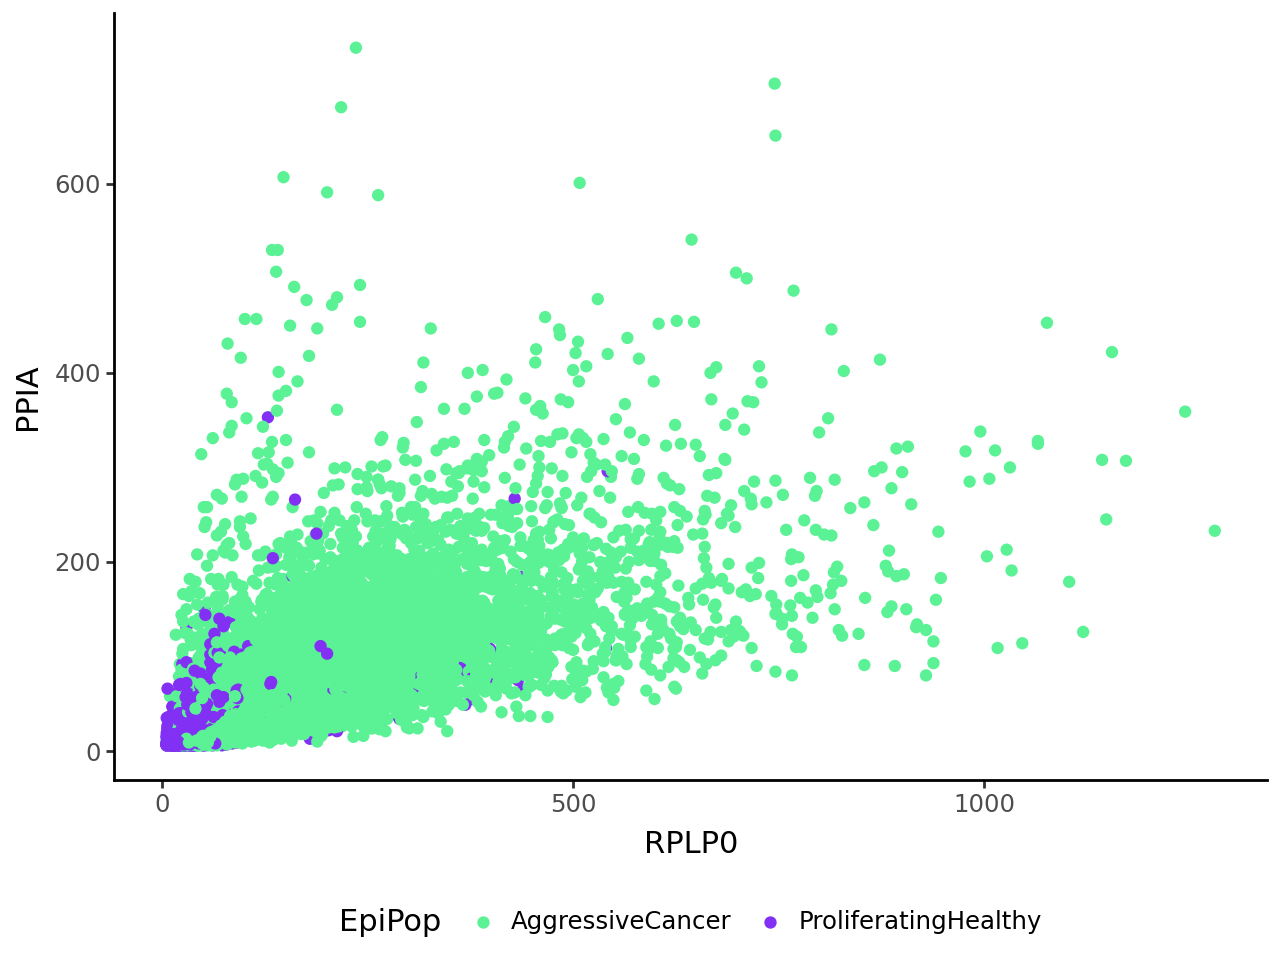

In [5]:
ggplot(expr, aes(x = "RPLP0", y = "PPIA", color = "EpiPop")) +\
    geom_point() +\
    scale_color_manual(values = ["#5bf295", "#8230f4"]) +\
    theme_classic() +\
    theme(legend_position = "bottom")

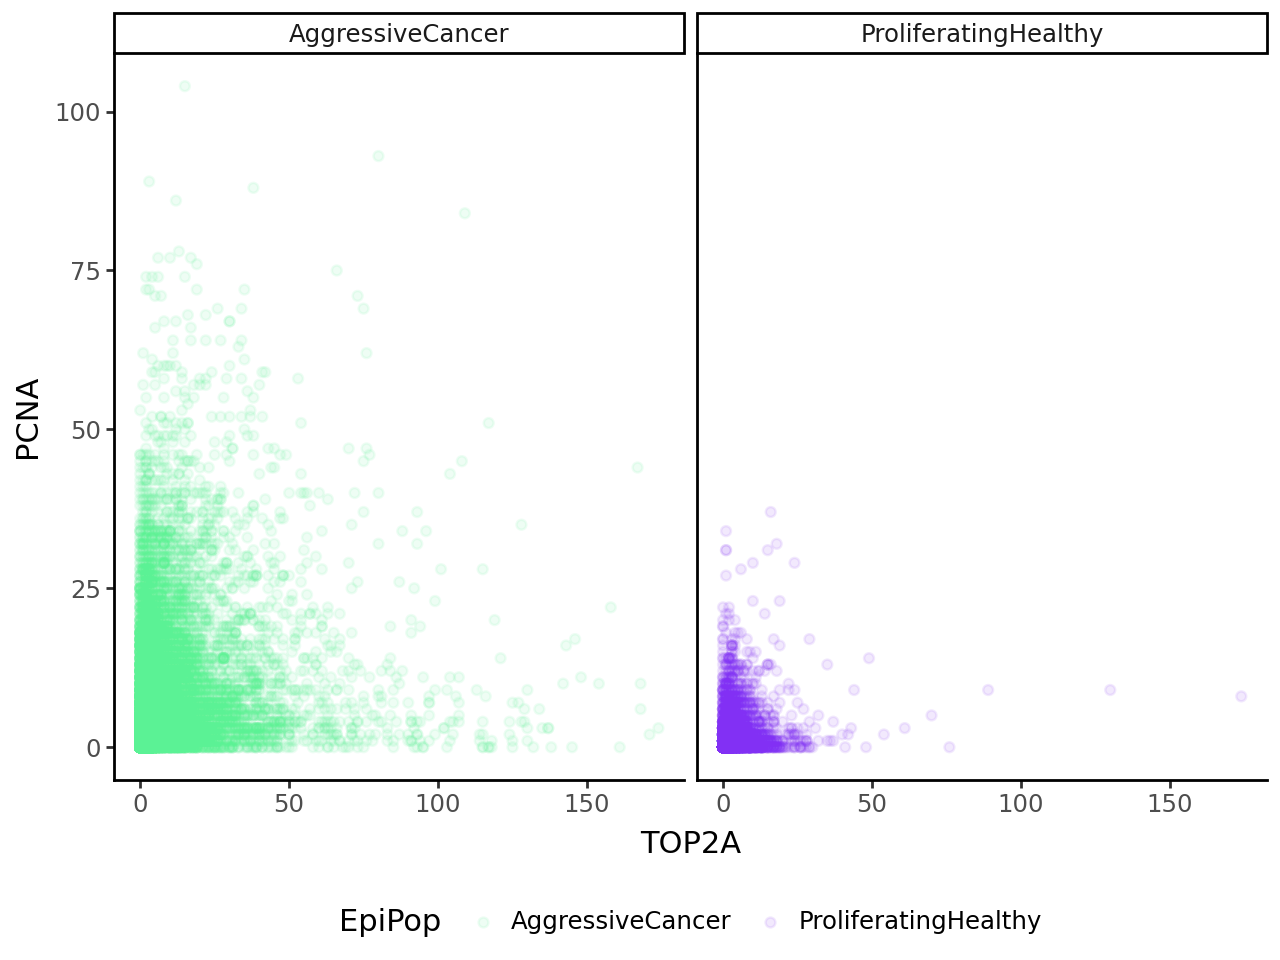

In [6]:
ggplot(expr, aes(x = "TOP2A", y = "PCNA", color = "EpiPop")) +\
    geom_point(alpha = 0.1) +\
    scale_color_manual(values = ["#5bf295", "#8230f4"]) +\
    theme_classic() +\
    theme(legend_position = "bottom") +\
    facet_wrap('~EpiPop')

In [7]:
# Compute geometric mean of reference genes
ref_expr = expr.loc[:,["MKI67"]].apply(lambda x: gmean(x), axis=1)
norm_expr = expr.loc[ref_expr > 0,["CYCS", "CPT1A", "SLC16A1", "SLC7A5", "SLC3A2", "GLUL", "TOP2A", "CA9"]]

norm_expr = norm_expr.div(ref_expr[ref_expr > 0] , axis=0)

# Rename values for clarity
norm_expr["Proliferation"] = expr.loc[ref_expr > 0,"EpiPop"].replace({"ProliferatingHealthy": "Healthy proliferation", 
                                                                      "AggressiveCancer": "Malignant proliferation"})

In [8]:
# Display violin plots of metabolic marker intensity per cell
# Split by aggressiveness (low = right violin, high = left violin)

# Reorder by pathway
path_order = ["TOP2A", "CYCS", "CPT1A", "SLC16A1", "SLC7A5", "SLC3A2", "GLUL", "CA9"]

# Convert to long format
df_long = pd.melt(norm_expr.loc[:,path_order+["Proliferation"]], id_vars=["Proliferation"], value_vars=path_order)

df_long["variable"] = pd.Categorical(df_long["variable"], 
    categories=path_order,
    ordered=True)

df_long["variable"] = df_long["variable"].replace({
    "CYCS": "CYCS\n(CytC)",
    "SLC16A1": "SLC16A1\n(MCT1)",
    "SLC7A5": "SLC7A5\n(CD98)",
    "SLC3A2": "SLC3A2\n(CD98)",
    "GLUL": "GLUL\n(GS)",
    "TOP2A": "TOP2A\n(negative)",
})

/tmp/ipykernel_1849865/580677146.py:14: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 4 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig6/expression_ki67_cancer_healthy_pelka.pdf


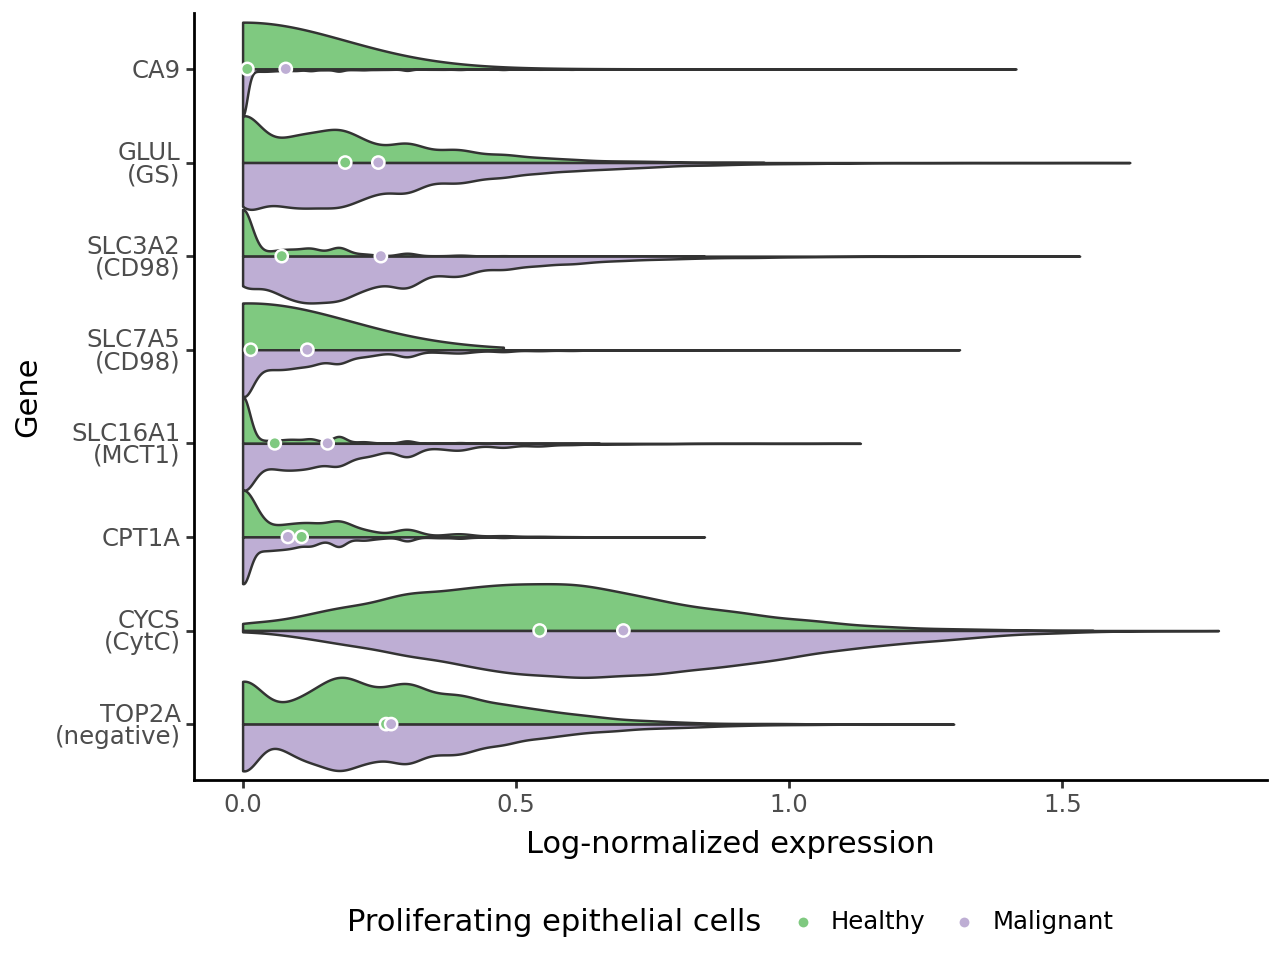

In [9]:
# Log transform
df_long["logvalue"] = np.log10(1 + df_long["value"])

# Rename proliferation categories for the legend
df_long["Proliferation_display"] = df_long["Proliferation"].replace({
    "Healthy proliferation": "Healthy", 
    "Malignant proliferation": "Malignant"
})

gp = ggplot(df_long, aes(x="variable", y="logvalue")) +\
    geom_violin(data=df_long.loc[df_long.Proliferation == "Healthy proliferation", :],
                fill="#7fc980",
                style="right",
                scale="width",
                width=1,
                adjust=1) +\
    geom_violin(data=df_long.loc[df_long.Proliferation == "Malignant proliferation", :],
                fill="#beaed4",
                style="left",
                scale="width",
                width=1,
                adjust=1) +\
    stat_summary(data=df_long,
                 mapping=aes(fill="Proliferation_display"),
                 fun_y=np.mean, geom='point', color='white',
                 size=2) +\
    scale_fill_manual(values=["#7fc980", "#beaed4"]) +\
    theme_classic() +\
    coord_flip() +\
    ylab("Log-normalized expression") +\
    xlab("Gene") +\
    theme(legend_position="bottom") +\
    guides(fill=guide_legend(title="Proliferating epithelial cells"))

ggsave(gp, "../../figures/fig6/expression_ki67_cancer_healthy_pelka.pdf", width = 4, height = 4)
gp

Note: ARG1 had median expression of 0 in both conditions.

## Healthy and malignant Ki67+ epithelial cells

In [10]:
enrich_healthy = pd.read_csv("../../data/pelka-reanalysis/EnrichmentProlifHealthy.csv", index_col=0)
assert np.all(np.isclose(enrich_healthy["AggressiveCancer P-Value"], enrich_healthy["ProliferatingHealthy P-Value"]))
# enrich_healthy = enrich_healthy.loc[enrich_healthy["AggressiveCancer P-Value"] < 0.05]
print(enrich_healthy.shape)
enrich_healthy.head()

(2022, 7)


,FeatureName,AggressiveCancer Average,AggressiveCancer Log2 Fold Change,AggressiveCancer P-Value,ProliferatingHealthy Average,ProliferatingHealthy Log2 Fold Change,ProliferatingHealthy P-Value
FeatureID,,,,,,,
ENSG00000168748,CA7,0.004639,-8.645118,4.584411e-119,1.882863,8.645118,4.584411e-119
ENSG00000044012,GUCA2B,0.027271,-6.764468,1.072193e-19,2.972806,6.764468,1.072193e-19
ENSG00000197888,UGT2B17,0.353647,-5.116223,1.432938e-107,12.274769,5.116223,1.432938e-107
ENSG00000269404,SPIB,0.062128,-5.011706,4.538280e-73,2.006838,5.011706,4.538280e-73
ENSG00000167434,CA4,0.041628,-5.006742,1.023447e-54,1.340475,5.006742,1.023447e-54


In [11]:
enrich_tumor = pd.read_csv("../../data/pelka-reanalysis/EnrichmentProlifCancer.csv", index_col=0)
# Drop LY6E and TGFBI, enriched by design
enrich_tumor.drop(["ENSG00000160932", "ENSG00000120708"], inplace=True)
# enrich_tumor = enrich_tumor.loc[enrich_tumor["AggressiveCancer P-Value"] < 0.05]
print(enrich_tumor.shape)
enrich_tumor.head()

(3300, 7)


,FeatureName,AggressiveCancer Average,AggressiveCancer Log2 Fold Change,AggressiveCancer P-Value,ProliferatingHealthy Average,ProliferatingHealthy Log2 Fold Change,ProliferatingHealthy P-Value
FeatureID,,,,,,,
ENSG00000229314,ORM1,1.528184,7.302675,1.066325e-23,0.009040,-7.302675,1.066325e-23
ENSG00000167244,IGF2,2.393336,7.101861,2.034298e-28,0.016788,-7.101861,2.034298e-28
ENSG00000172016,REG3A,36.319708,6.400993,4.720629e-18,0.429391,-6.400993,4.720629e-18
ENSG00000100604,CHGA,1.099934,5.877206,2.607789e-01,0.018080,-5.877206,2.607789e-01
ENSG00000185269,NOTUM,1.081377,5.666247,7.671410e-17,0.020662,-5.666247,7.671410e-17


In [12]:
# Merge tables
enrich_tumor = pd.concat([enrich_tumor, enrich_healthy])

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 4 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig6/volcano_cancer_healthy_pelka.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 5311 rows containing missing values.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 5311 rows containing missing values.


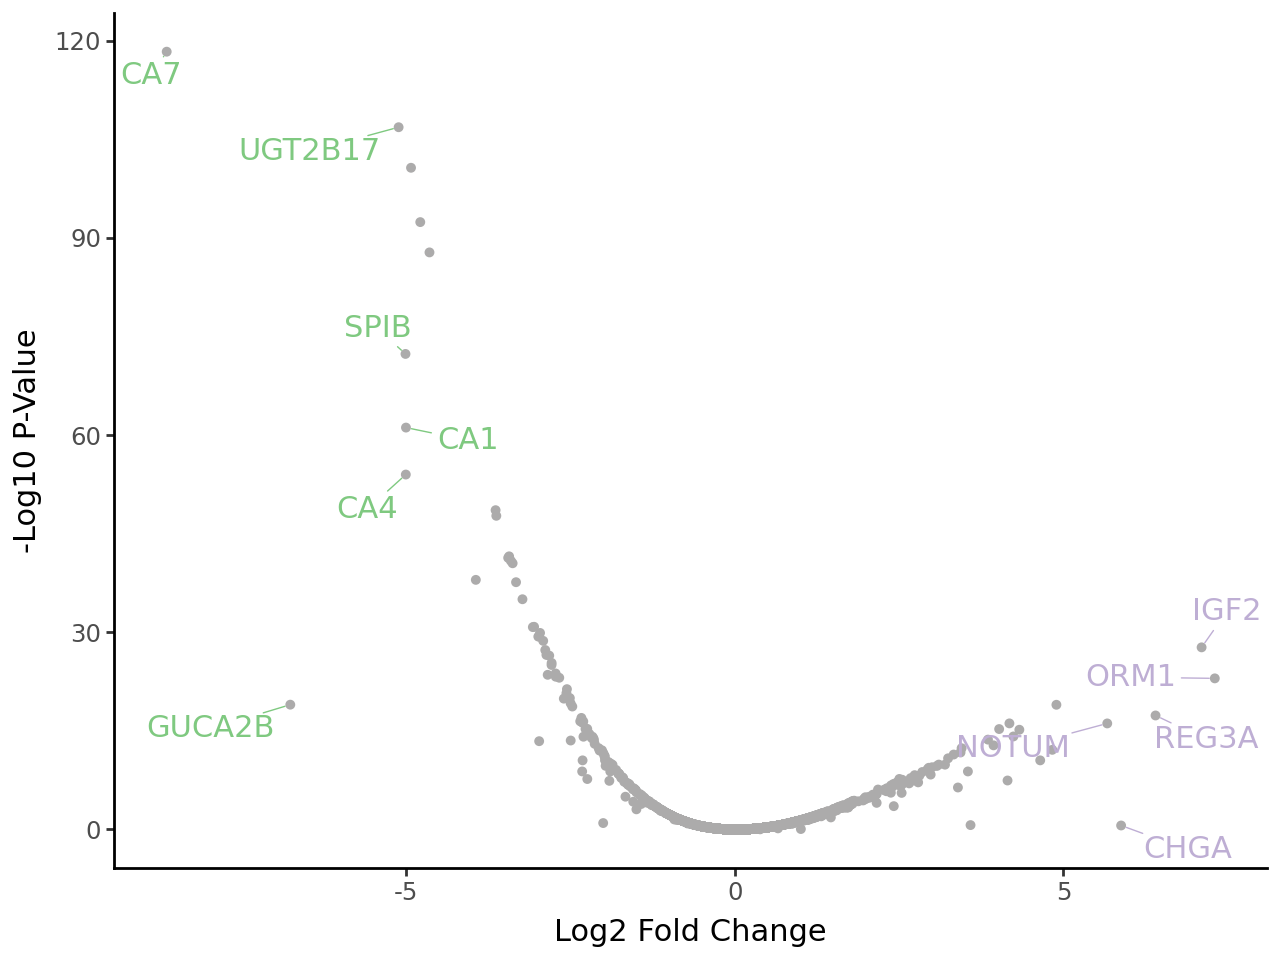

In [13]:
# Volcano plot

# -log10(p-value)
enrich_tumor["logPval"] = -enrich_tumor["AggressiveCancer P-Value"].apply(np.log10)
# Label points with their `FeatureName` if log2fc > 5
enrich_tumor["label"] =np.where(np.abs(enrich_tumor["AggressiveCancer Log2 Fold Change"]) > 5,
             enrich_tumor["FeatureName"],
             pd.NA)
# If log2fc > 0, class = Cancer, else class = Healthy
enrich_tumor["class"] = np.where(enrich_tumor["AggressiveCancer Log2 Fold Change"] > 0,
                                  "Malignant",
                                  "Healthy")

gp = (ggplot(enrich_tumor, aes(x = "AggressiveCancer Log2 Fold Change",
                               y = "logPval"))
    + geom_point(size = 1, color = "#acabab")
    + geom_text(aes(label="label", color="class"), 
                adjust_text={
                    'arrowprops': {
                        'arrowstyle': '-',
                    }
                })
    + theme_classic()
    + scale_color_manual(values=["#7fc980", "#beaed4"])
    + labs(x = "Log2 Fold Change",
           y = "-Log10 P-Value")
    + theme(legend_position="none")
)

ggsave(gp, "../../figures/fig6/volcano_cancer_healthy_pelka.pdf", width = 4, height = 4)
gp

In [14]:
# See https://decoupler.readthedocs.io/en/latest/notebooks/bulk/rna.html
import decoupler as dc
data = pd.DataFrame(enrich_tumor["AggressiveCancer Log2 Fold Change"]).set_index(enrich_tumor["FeatureName"]).T

collectri = dc.op.collectri(organism='human')
tf_acts, tf_padj = dc.mt.ulm(data=data, net=collectri)
msk = (tf_padj.T < 0.05).iloc[:, 0]
tf_acts = tf_acts.loc[:, msk]

tf_acts

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


,AP1,ARID4B,ARX,ASCL1,ATF3,ATF4,CEBPD,CEBPE,CREB1,CREB3,...,STAT3,TBX3,TCF4,TCF7L2,TEAD1,TFCP2,TGFB1I1,ZFHX3,ZKSCAN7,ZNF382
AggressiveCancer Log2 Fold Change,6.599392,-4.788077,6.057014,2.716774,4.149033,3.02119,3.987555,4.505471,3.962875,2.954234,...,4.939647,-3.431421,4.934103,6.063794,2.796203,3.645178,3.085107,-2.998101,4.355932,-3.037132


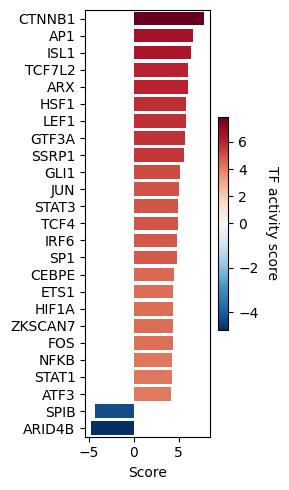

In [15]:
from matplotlib import pyplot as plt

# Create the barplot
dc.pl.barplot(
    data=tf_acts,
    name='AggressiveCancer Log2 Fold Change',
    top=25,
    figsize=(3, 5)
)

# Get the current figure and access the colorbar
fig = plt.gcf()
axes = fig.get_axes()

# The colorbar is the second axes (index 1)
colorbar_ax = axes[1]
colorbar_ax.set_ylabel('TF activity score', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

In [16]:
np.transpose(tf_acts).sort_values(by = "AggressiveCancer Log2 Fold Change",
                                  ascending=False)

,AggressiveCancer Log2 Fold Change
CTNNB1,7.851914
AP1,6.599392
ISL1,6.416877
TCF7L2,6.063794
ARX,6.057014
...,...
TBX3,-3.431421
IRX1,-3.565744
KLF15,-3.663500
SPIB,-4.294952


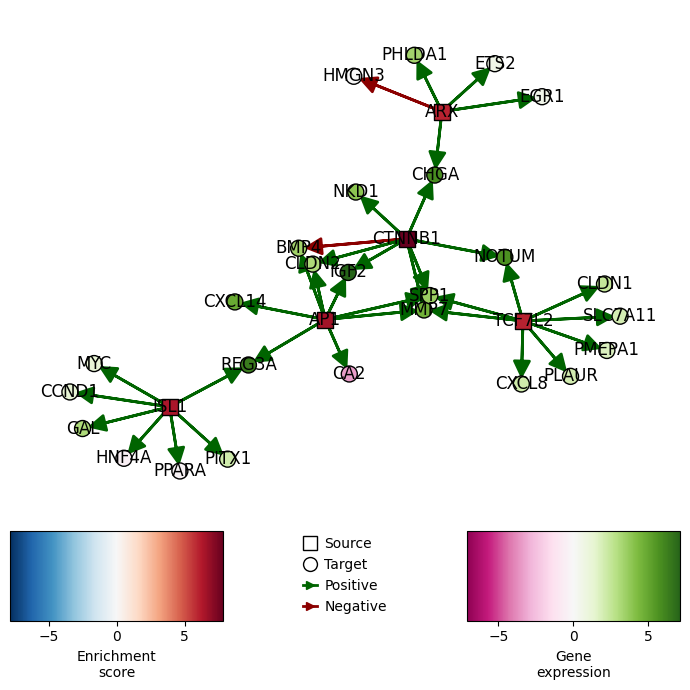

In [17]:
dc.pl.network(
    net=collectri,
    data=data,
    score=tf_acts,
    sources=['CTNNB1', 'AP1', 'ISL1', 'TCF7L2', 'ARX'],
    targets=8,
    figsize=(7, 7),
    vcenter=True,
    by_abs=True,
    t_cmap='PiYG',
    size_node=8
)
plt.savefig("../../figures/fig6/tf_network_pelka.pdf", 
    bbox_inches='tight')
plt.show()

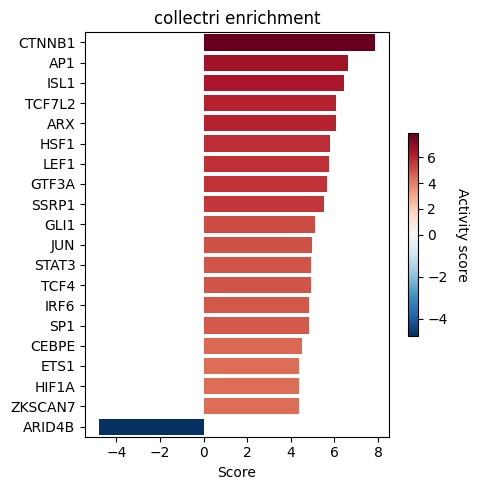

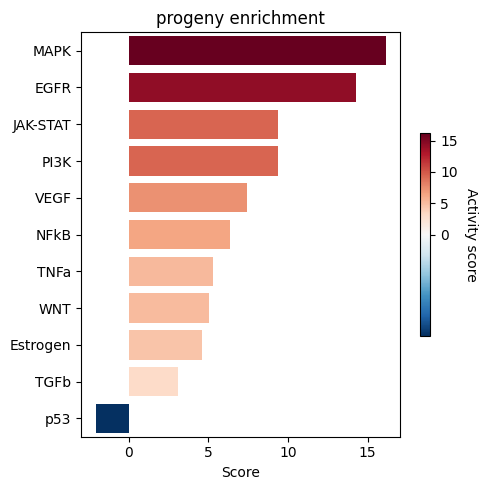

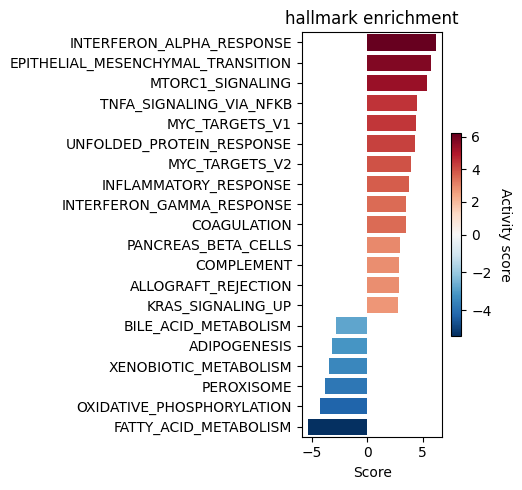

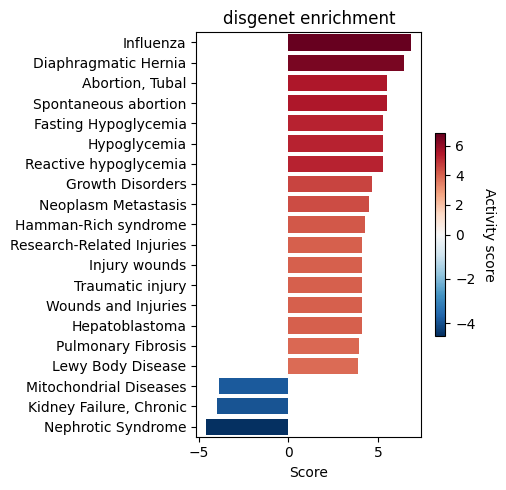

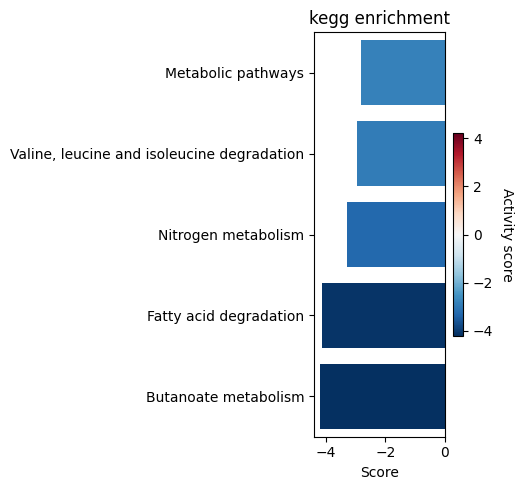

In [18]:
# Prepare resources
disgenet_df = dc.op.resource('DisGeNet')
disgenet_df.rename(columns={"disease": "source", "genesymbol": "target"}, inplace=True)
disgenet_df = disgenet_df.loc[:,["target", "source"]].drop_duplicates()
kegg_df = dc.op.resource("KEGG-PC")
kegg_df.rename(columns={"pathway": "source", "genesymbol": "target"}, inplace=True)
kegg_df = kegg_df.loc[:,["target", "source"]].drop_duplicates()
assert len(set(kegg_df.target).intersection(set(data.columns))) > 0

resources = {
    "collectri": dc.op.collectri(organism='human'),
    "progeny": dc.op.progeny(organism='human'),
    "hallmark": dc.op.hallmark(organism='human'),
    "disgenet": disgenet_df,
    "kegg": kegg_df,
}

for res_name, res in resources.items():
    acts, padj = dc.mt.ulm(data=data, net=res)
    
    # Filter by sign padj
    msk = (padj.T < 0.05).iloc[:, 0]
    acts = acts.loc[:, msk]

    if acts.shape[1] == 0:
        print(f"No significant results for {res_name}.")
        continue
    
    dc.pl.barplot(
        data=acts,
        name='AggressiveCancer Log2 Fold Change',
        top=20,
        figsize=(5, 5)
    )
    
    # Add colorbar legend
    fig = plt.gcf()
    axes = fig.get_axes()
    if len(axes) > 1:
        colorbar_ax = axes[1]
        colorbar_ax.set_ylabel('Activity score', rotation=270, labelpad=15)
    
    plt.title(f"{res_name} enrichment")
    plt.tight_layout()
    
    # Export each enrichment plot as PDF
    plt.savefig(f"../../figures/fig6/{res_name}_enrichment_pelka.pdf", 
                bbox_inches='tight')
    
    plt.show()